# LDA (Latent Dirichlet Allocation) & LSI (Latent Semantic Indexing)

#### Set parameters for how final model results will be saved

In [1]:
tokenized_run_name = "unweighted_1_tokens"  #manually input the filename (no extension) to be used as input

In [2]:
data_directory = "../data/"
output_directory = "../outputs/"

In [3]:
base_model_type = "lda_lsi"
model_name_suffix = ""  #default should be blank; use to make note of any other mods
run_number = 1

In [4]:
final_model_name = f"{base_model_type}_{tokenized_run_name[:-7]}_run{run_number}{model_name_suffix}"

#### Imports

In [5]:
# general use
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# # for LDA modeling & presentation
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

# # for LSA modeling
from sklearn.decomposition import TruncatedSVD

# for progress bar on loops
from tqdm import tqdm

#### Read in Dataframe with tokenized text

In [6]:
df = pd.read_csv(f"{data_directory}{tokenized_run_name}.csv")
df.head()

,name,href,tokenized_text
0,Game of Thrones,/title/tt0944947/,nine noble family fight control land westeros ...
1,Prison Break,/title/tt0455275/,due political conspiracy innocent man send dea...
2,Vikings,/title/tt2306299/,vikings transport us brutal mysterious world r...
3,The Boys,/title/tt1190634/,group vigilante set take corrupt superheroes a...
4,The Mandalorian,/title/tt8111088/,travel lone bounty hunter outer reach galaxy f...


In [7]:
df.isna().sum()

name              0
href              0
tokenized_text    0
dtype: int64

In [8]:
df.fillna("",inplace=True)

#### Count Vectorization & TfIDF

In [9]:
# Function draws heavily from Jiamei Wang's code: 
# Technique reference: (Jiamei Wang) https://medium.com/swlh/sentiment-analysis-topic-modeling-for-hotel-reviews-6b83653f5b08
# (Separated into sub-functions to allow for faster parameter tuning)

def make_tfidf(input_df, text_colname='tokenized_text'):
    '''
    INPUTS:
        input_df - dataframe that contains the combined text summaries
        text_colname: name of column that contains the combined text summaries
        
    OUTPUTS:
        dtm_tfidf - document-term matrix in the tfidf format
        tfidf_vectorizer - word frequency in the reviews
    '''
    docs_raw = input_df[text_colname].tolist()

    #************   Step 1: Convert to document-term matrix   ************#

    #Transform text to vector form using the vectorizer object 
    cvec = CountVectorizer(strip_accents = 'unicode',
                            stop_words = 'english',
                            lowercase = True,
                            token_pattern = r'\b[a-zA-Z]{3,}\b', # num chars > 3 to avoid some meaningless words
                            max_df = 0.5,                        # discard words that appear in > 50% of the reviews
                            min_df = 10)                         # discard words that appear in < 10 reviews    

    #apply transformation
    tfidf_vectorizer = TfidfVectorizer(**cvec.get_params())

    #convert to document-term matrix
    dtm_tfidf = tfidf_vectorizer.fit_transform(docs_raw)  

    print("The shape of the tfidf is {}, meaning that there are {} non-unique words in {} and {} tokens made through the filtering process.".\
              format(dtm_tfidf.shape,dtm_tfidf.shape[0], text_colname, dtm_tfidf.shape[1]))
    
    # return tf_vectorizer, tfidf_vectorizer, dtm_tfidf
    return tfidf_vectorizer, dtm_tfidf

In [10]:
tfidf_vectorizer, dtm_tfidf = make_tfidf(df, 'tokenized_text')

d:\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:2070: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'numpy.int64'> 'dtype' will be converted to np.float64.
  warnings.warn(


The shape of the tfidf is (2484, 16937), meaning that there are 2484 non-unique words in tokenized_text and 16937 tokens made through the filtering process.


#### Grid Search for best LDA model

In [11]:
# Define Grid Search Parameters
search_params = {'n_components': [5, 10, 20, 30],       # testing suggests it always picks 5 topics as "best"
                    'learning_decay': [.5, .7, .9]}     # does not always return same "best" learning decay

In [12]:
# Function draws from Jiamei Wang's code, with modifications & optimizations: 
# Technique reference: (Jiamei Wang) https://medium.com/swlh/sentiment-analysis-topic-modeling-for-hotel-reviews-6b83653f5b08
# (Separated into sub-functions to allow for faster parameter tuning)

def lda_gridsearch(dtm_tfidf, search_params):
    '''
    INPUTS:
        dtm_tfidf - document-term matrix in the tfidf format
        search_params - a dictionary of parameters to be used in the grid search
        
    OUTPUTS:
        model_gs - the GridSearchCV object
        best_lda_model - the best model, as determined by the grid search
    '''

    #*******   Step 2: GridSearch & parameter tuning to find the optimal LDA model   *******#

    # Init the Model
    lda = LatentDirichletAllocation()

    # Init Grid Search Class
    model_gs = GridSearchCV(lda, param_grid=search_params, n_jobs=8, verbose=3)

    # Do the Grid Search
    model_gs.fit(dtm_tfidf)

    #*****  Step 3: Output the optimal lda model and its parameters  *****#

    # Best Model
    best_lda_model = model_gs.best_estimator_

    # Model Parameters
    print("Best Model's Params: ", model_gs.best_params_)

    # Log Likelihood Score: Higher the better
    print("Model Log Likelihood Score: ", model_gs.best_score_)

    # Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
    print("Model Perplexity: ", best_lda_model.perplexity(dtm_tfidf))

    return model_gs, best_lda_model

In [13]:
model_gs, best_lda_model = lda_gridsearch(dtm_tfidf, search_params)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Model's Params:  {'learning_decay': 0.7, 'n_components': 5}
Model Log Likelihood Score:  -69916.62459166956
Model Perplexity:  24387.628732517267


#### Plotting LDA model performance

In [14]:
# Function draws from Jiamei Wang's code, with modifications & optimizations: 
# Technique reference: (Jiamei Wang) https://medium.com/swlh/sentiment-analysis-topic-modeling-for-hotel-reviews-6b83653f5b08
# (Separated into sub-functions to allow for faster parameter tuning)

def lda_plot_performance(model_gs, search_params):
    ''' 
    INPUTS:
        model_gs - the GridSearchCV object
        
    OUTPUTS:
        A graph comparing LDA Model Performance Scores with different params
    '''

    #***********   Step 4: Compare LDA Model Performance Scores   ***********#

    #Get Log Likelihoods from Grid Search Output
    gscore=model_gs.cv_results_

    log_likelihoods = {}
    for i in search_params['learning_decay']:
        log_likelihoods[i] = [gscore['mean_test_score'][gscore['params'].index(v)] for v in gscore['params'] if v['learning_decay']==i]

    # Show graph
    plt.figure(figsize=(12, 8))
    for i in log_likelihoods:
        plt.plot(search_params['n_components'], log_likelihoods[i], label=i)
 
    plt.title("Choosing Optimal LDA Model")
    plt.xlabel("Num Topics")
    plt.ylabel("Log Likelihood Scores")
    plt.legend(title='Learning decay', loc='best')
    plt.show()
    
    return

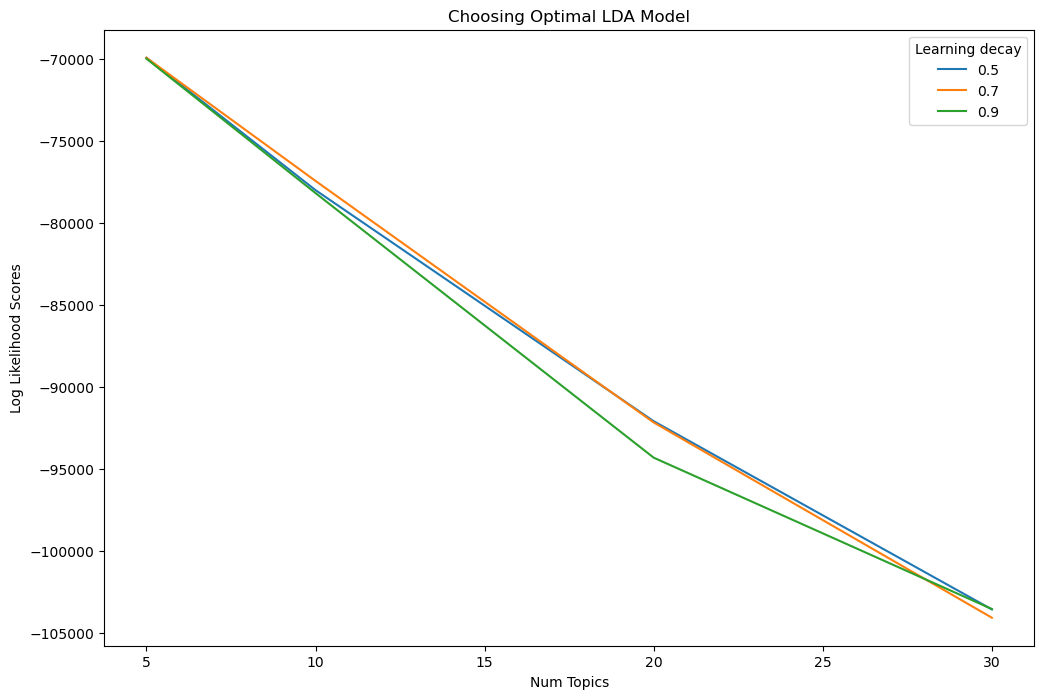

In [15]:
lda_plot_performance(model_gs, search_params)

#### (optional) Combined function for creating "best" LDA model with performance plot

In [16]:
# Technique reference: (Jiamei Wang) https://medium.com/swlh/sentiment-analysis-topic-modeling-for-hotel-reviews-6b83653f5b08
# (Separated into sub-functions to allow for more convenient parameter tuning)
# Once tuned/optimized, all 3 sub-functions can be run together in one command, wholly recreating the method used in the source referenced above

def optimal_lda_model(input_df, text_colname, search_params):
    '''
    INPUTS:
        input_df - dataframe that contains the combined text summaries
        text_colname: name of column that contains the combined text summaries
        search_params - a dictionary of parameters to be used in the grid search
        
    OUTPUTS:
        best_lda_model - the best model, as determined by the grid search
        dtm_tfidf - document-term matrix in the tfidf format
        tfidf_vectorizer - word frequency in the reviews
    '''
    
    tfidf_vectorizer, dtm_tfidf = make_tfidf(input_df, text_colname)
    model_gs, best_lda_model = lda_gridsearch(dtm_tfidf, search_params)
    lda_plot_performance(model_gs, search_params)

    return best_lda_model, dtm_tfidf, tfidf_vectorizer

In [17]:
# (Same as above, in one single function call)

# best_lda_model, dtm_tfidf, tfidf_vectorizer = optimal_lda_model(df, 'combined_text', search_params)

#### Display topic keywords & weights

In [18]:
# Function excerpted directly with no additional modifications from: (Jiamei Wang)
# https://medium.com/swlh/sentiment-analysis-topic-modeling-for-hotel-reviews-6b83653f5b08

#Create a function to inspect the topics we created 
def display_topics(model, feature_names, n_top_words):
    '''
    INPUTS:
        model - the model we created
        feature_names - tells us what word each column in the matric represents
        n_top_words - number of top words to display
    OUTPUTS:
        a dataframe that contains the topics we created and the weights of each token
    '''
    topic_dict = {}
    for topic_idx, topic in tqdm(enumerate(model.components_)):
        topic_dict["Topic %d words" % (topic_idx+1)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-n_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx+1)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-n_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)


In [19]:
lda_topic_words = display_topics(best_lda_model, tfidf_vectorizer.get_feature_names_out(), n_top_words = 30) 
lda_topic_words.head(10)

5it [00:00, 555.36it/s]


,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights
0,maniac,1.1,anime,46.4,hui,0.2,kim,6.8,hostages,1.0
1,clap,0.2,netflix,43.4,seol,0.2,jung,6.4,carlisle,0.2
2,whatsoever,0.2,seasons,37.1,maniac,0.2,soo,6.1,georgian,0.2
3,manic,0.2,comedy,35.5,shim,0.2,hee,5.3,octane,0.2
4,cells,0.2,manga,35.2,hak,0.2,min,5.2,assassinate,0.2
5,ascent,0.2,school,30.4,chae,0.2,jin,5.1,tactical,0.2
6,caravan,0.2,bbc,29.9,hostages,0.2,korean,5.1,seize,0.2
7,battery,0.2,crime,28.8,euphoria,0.2,yoon,5.0,hostage,0.2
8,hysterical,0.2,game,28.7,fifa,0.2,hyun,4.8,thrust,0.2
9,pharmaceutical,0.2,pilot,28.4,utilized,0.2,joon,4.4,sanders,0.2


#### Visualizing LDA output with the pyLDAvis library

In [20]:
# Topic Modelling Visualization for the show description texts
pyLDAvis.sklearn.prepare(best_lda_model, dtm_tfidf, tfidf_vectorizer)

d:\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.092276  0.000193       1        1  93.200382
3      0.032698  0.001689       2        1   2.151180
0      0.019883 -0.000854       3        1   1.550448
4      0.019874 -0.000769       4        1   1.550111
2      0.019821 -0.000259       5        1   1.547879, topic_info=            Term       Freq      Total Category  logprob  loglift
8416         kim   8.000000   8.000000  Default  30.0000  30.0000
8708         lee  11.000000  11.000000  Default  29.0000  29.0000
8495      korean   4.000000   4.000000  Default  28.0000  28.0000
11035       park  10.000000  10.000000  Default  27.0000  27.0000
8123         jin   2.000000   2.000000  Default  26.0000  26.0000
...          ...        ...        ...      ...      ...      ...
12448     refute   0.026906   0.486874   Topic5  -9.7370   1.2726
8218    judicial   0.026906   0.493009   Topic5  -9.7371   1.2601
7448   impactful   0.026906   0.498564   Topic5  -9.7371   1.2489
16498    webtoon   0.026906   0.669474   Topic5  -9.7371   0.9541
14987        tae   0.026906   0.902321   Topic5  -9.7371   0.6557

[285 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
12         1  0.973133          abc
635        1  0.987972    animation
641        1  0.997311        anime
923        1  1.617764       ascent
957        1  0.786438  assassinate
...      ...       ...          ...
16793      1  0.721770     wrestler
16802      1  1.025635        wrong
16850      2  1.145360         yeon
16863      2  0.958799          yoo
16864      2  0.819757         yoon

[138 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 1, 5, 3])

#### Generate results (fit-transorm) from a LDA model and tfidf matrix

In [21]:
lda_results = best_lda_model.fit_transform(dtm_tfidf) 

#### Append the LDA topic % matches onto the results dataframe

In [22]:
# Technique reference: (Mimi Dutta) https://www.analyticsvidhya.com/blog/2021/07/topic-modelling-with-lda-a-hands-on-introduction/

def make_lda_topic_pct_cols(lda_results, df_to_append_to, name_prefix=""):
    
    for j in tqdm(range(len(df_to_append_to))):
        for i,topic in enumerate(lda_results[j]):
            df_to_append_to.loc[j, f"{name_prefix}lda_topic{i}_match_pct"] = topic
    return
        

In [23]:
make_lda_topic_pct_cols(lda_results, df)

100%|██████████| 2484/2484 [00:00<00:00, 4130.97it/s]


In [24]:
df.head()

,name,href,tokenized_text,lda_topic0_match_pct,lda_topic1_match_pct,lda_topic2_match_pct,lda_topic3_match_pct,lda_topic4_match_pct
0,Game of Thrones,/title/tt0944947/,nine noble family fight control land westeros ...,0.008690,0.965214,0.008716,0.008690,0.008690
1,Prison Break,/title/tt0455275/,due political conspiracy innocent man send dea...,0.011481,0.953645,0.011911,0.011481,0.011481
2,Vikings,/title/tt2306299/,vikings transport us brutal mysterious world r...,0.013498,0.945991,0.013514,0.013498,0.013498
3,The Boys,/title/tt1190634/,group vigilante set take corrupt superheroes a...,0.009292,0.962832,0.009292,0.009292,0.009292
4,The Mandalorian,/title/tt8111088/,travel lone bounty hunter outer reach galaxy f...,0.015753,0.936628,0.016112,0.015753,0.015754


In [25]:
df.shape

(2484, 8)

# LSA model

In [26]:
# Technique reference: (Avinash Navlani) https://machinelearninggeek.com/latent-semantic-indexing-using-scikit-learn/


# Define the number of topics or components
num_components=10

# Create SVD object
lsa = TruncatedSVD(n_components=num_components, n_iter=100, random_state=42)

# Fit SVD model on data
lsa_results = lsa.fit_transform(dtm_tfidf)

# Get Singular values and Components 
Sigma = lsa.singular_values_ 
V_transpose = lsa.components_.T

In [27]:
# Technique reference: (Avinash Navlani) https://machinelearninggeek.com/latent-semantic-indexing-using-scikit-learn/

# Print the topics with their terms

def lsa_topics_out(tfidf_vectorizer, svd_object):
    terms = tfidf_vectorizer.get_feature_names_out()

    for index, component in enumerate(svd_object.components_):
        zipped = zip(terms, component)
        top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10]
        top_terms_list=list(dict(top_terms_key).keys())
        print("Topic "+str(index)+": ",top_terms_list)

    return

In [28]:
lsa_topics_out(tfidf_vectorizer, lsa)

Topic 0:  ['anime', 'manga', 'netflix', 'seasons', 'comedy', 'japanese', 'school', 'game', 'voiced', 'novel']
Topic 1:  ['anime', 'manga', 'japanese', 'volume', 'english', 'japan', 'voiced', 'shonen', 'animation', 'license']
Topic 2:  ['kim', 'jung', 'soo', 'korean', 'lee', 'jin', 'hee', 'min', 'hyun', 'yoon']
Topic 3:  ['voiced', 'cartoon', 'disney', 'animation', 'voice', 'animated', 'nickelodeon', 'game', 'marvel', 'batman']
Topic 4:  ['bbc', 'planet', 'war', 'programme', 'documentary', 'earth', 'british', 'miniseries', 'london', 'novel']
Topic 5:  ['voiced', 'crime', 'detective', 'japanese', 'netflix', 'police', 'murder', 'dragon', 'batman', 'english']
Topic 6:  ['voiced', 'detective', 'bbc', 'police', 'murder', 'crime', 'japanese', 'programme', 'case', 'english']
Topic 7:  ['trek', 'detective', 'police', 'fbi', 'cbs', 'marvel', 'team', 'crime', 'nbc', 'agent']
Topic 8:  ['netflix', 'marvel', 'crime', 'documentary', 'singh', 'disney', 'indian', 'murder', 'mcu', 'killer']
Topic 9:  [

In [29]:
# Technique reference: (Mimi Dutta) https://www.analyticsvidhya.com/blog/2021/07/topic-modelling-with-lda-a-hands-on-introduction/

def make_lsa_topic_pct_cols(lsa_results, df_to_append_to):
    for j in tqdm(range(len(df_to_append_to))):
        for i,topic in enumerate(lsa_results[j]):
            df_to_append_to.loc[j, f"lsa_topic{i}_cos_match"] = topic
    return

In [30]:
make_lsa_topic_pct_cols(lsa_results, df)

100%|██████████| 2484/2484 [00:01<00:00, 2095.09it/s]


In [31]:
df.head()

,name,href,tokenized_text,lda_topic0_match_pct,lda_topic1_match_pct,lda_topic2_match_pct,lda_topic3_match_pct,lda_topic4_match_pct,lsa_topic0_cos_match,lsa_topic1_cos_match,lsa_topic2_cos_match,lsa_topic3_cos_match,lsa_topic4_cos_match,lsa_topic5_cos_match,lsa_topic6_cos_match,lsa_topic7_cos_match,lsa_topic8_cos_match,lsa_topic9_cos_match
0,Game of Thrones,/title/tt0944947/,nine noble family fight control land westeros ...,0.008690,0.965214,0.008716,0.008690,0.008690,0.347465,-0.026348,-0.027834,0.047141,0.108406,-0.068647,-0.038896,-0.019839,0.015816,-0.000741
1,Prison Break,/title/tt0455275/,due political conspiracy innocent man send dea...,0.011481,0.953645,0.011911,0.011481,0.011481,0.275600,-0.063611,-0.018882,-0.034794,-0.037084,-0.009950,0.017834,0.078940,-0.046593,-0.043410
2,Vikings,/title/tt2306299/,vikings transport us brutal mysterious world r...,0.013498,0.945991,0.013514,0.013498,0.013498,0.186671,-0.034689,-0.016880,0.003262,0.066695,0.000323,-0.048242,-0.040307,0.003310,-0.000493
3,The Boys,/title/tt1190634/,group vigilante set take corrupt superheroes a...,0.009292,0.962832,0.009292,0.009292,0.009292,0.295748,-0.066046,-0.015771,0.019903,-0.008302,0.014673,-0.080466,0.024328,0.039867,-0.007650
4,The Mandalorian,/title/tt8111088/,travel lone bounty hunter outer reach galaxy f...,0.015753,0.936628,0.016112,0.015753,0.015754,0.152946,-0.010827,-0.011497,0.076112,0.033428,0.010131,-0.083739,0.041084,0.043047,0.027144


In [32]:
df.shape

(2484, 18)

## Force LDA evaluate with different parameters

#### Generate same output items for forced alternate (20+ topic) model

In [33]:
# Define Grid Search Parameters
search_params2 = {'n_components': [20, 30],       # testing suggests it always picks 5 topics as "best"
                    'learning_decay': [.5, .7, .9]}     # does not always return same "best" learning decay

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Model's Params:  {'learning_decay': 0.7, 'n_components': 20}
Model Log Likelihood Score:  -92263.04730569989
Model Perplexity:  89483.33047902002


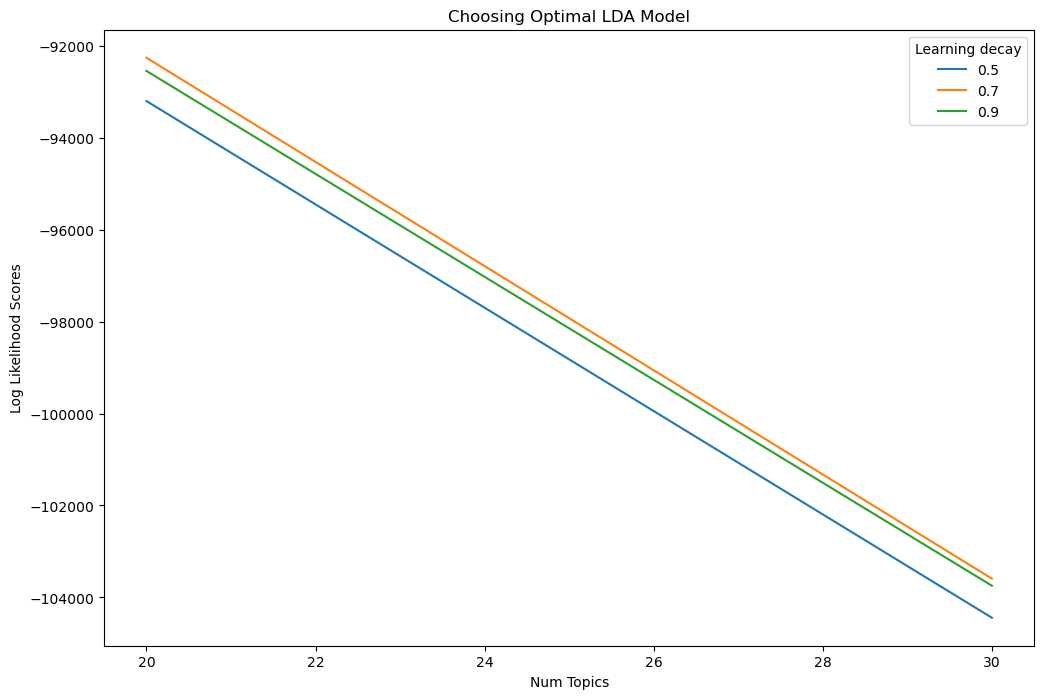

In [34]:
# tfidf_vectorizer, dtm_tfidf = make_tfidf(input_df, text_colname)
model_gs2, best_lda_model2 = lda_gridsearch(dtm_tfidf, search_params2)
lda_plot_performance(model_gs2, search_params2)

In [35]:
lda_topic_words2 = display_topics(best_lda_model2, tfidf_vectorizer.get_feature_names_out(), n_top_words = 30) 
lda_topic_words2.head()

20it [00:00, 745.41it/s]


,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights,...,Topic 16 words,Topic 16 weights,Topic 17 words,Topic 17 weights,Topic 18 words,Topic 18 weights,Topic 19 words,Topic 19 weights,Topic 20 words,Topic 20 weights
0,pharmacist,0.8,ghoul,3.1,kim,7.9,ramsay,1.8,manga,13.8,...,nye,1.6,recess,0.8,cosmos,2.7,picard,0.9,callaghan,1.0
1,jinn,0.7,attenborough,2.0,jung,6.2,nightmares,1.0,shonen,6.8,...,kimmy,1.5,deadwood,0.6,dune,1.6,partridge,0.8,mirren,0.9
2,sneaky,0.6,slasher,1.2,soo,5.9,bower,0.9,anime,5.4,...,rugrats,1.3,smiley,0.6,wormhole,0.9,bonanza,0.8,animaniacs,0.9
3,keeping,0.4,hannibal,1.0,korean,5.7,smallville,0.9,dragon,4.5,...,rosemary,0.9,wei,0.6,mayfair,0.8,doe,0.8,thorpe,0.8
4,solicitor,0.4,astronauts,0.8,jin,5.2,dickinson,0.7,kodansha,4.2,...,serenity,0.9,gao,0.2,evangelion,0.8,sas,0.7,pinky,0.7


In [36]:
# Topic Modelling Visualization for the show description texts
pyLDAvis.sklearn.prepare(best_lda_model2, dtm_tfidf, tfidf_vectorizer)

d:\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.210146 -0.168229       1        1  51.546548
14    -0.220399 -0.155693       2        1  35.506444
4      0.006071  0.147749       3        1   3.259077
13     0.001361  0.114722       4        1   2.590032
2     -0.001361  0.019755       5        1   0.950227
9      0.000295  0.004443       6        1   0.436384
1      0.000455  0.003691       7        1   0.433033
11     0.000187  0.003155       8        1   0.418290
17     0.000260  0.003429       9        1   0.417126
8      0.000259  0.003202      10        1   0.415893
10     0.000217  0.002776      11        1   0.411696
5      0.000290  0.002685      12        1   0.411223
3      0.000246  0.002730      13        1   0.408981
15     0.000367  0.002489      14        1   0.405081
18     0.000294  0.002494      15        1   0.403721
19     0.000197  0.002273      16        1   0.400984
12     0.000274  0.002025      17        1   0.397848
7      0.000280  0.002144      18        1   0.396634
16     0.000267  0.002069      19        1   0.395448
0      0.000293  0.002092      20        1   0.395334, topic_info=              Term       Freq      Total Category  logprob  loglift
9254         manga  26.000000  26.000000  Default  30.0000  30.0000
641          anime  39.000000  39.000000  Default  29.0000  29.0000
8708           lee  10.000000  10.000000  Default  28.0000  28.0000
8416           kim   8.000000   8.000000  Default  27.0000  27.0000
11035         park   9.000000   9.000000  Default  26.0000  26.0000
...            ...        ...        ...      ...      ...      ...
6695        hadadi   0.006844   0.524589  Topic20  -9.7412   1.1939
3767         darcy   0.006844   0.544476  Topic20  -9.7412   1.1567
5951     forrester   0.006844   1.145654  Topic20  -9.7412   0.4128
3968   deliciously   0.006844   0.519984  Topic20  -9.7412   1.2027
12708     reshoots   0.006844   0.512116  Topic20  -9.7412   1.2180

[950 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
12         1  0.828329         abc
12         2  0.146176         abc
141        1  0.942604      action
141        2  0.055447      action
164        1  0.982395  adaptation
...      ...       ...         ...
16846      4  0.688480      yellow
16847      3  0.768430         yen
16850      5  0.856621        yeon
16863      5  0.703616         yoo
16864      5  0.559780        yoon

[351 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 15, 5, 14, 3, 10, 2, 12, 18, 9, 11, 6, 4, 16, 19, 20, 13, 8, 17, 1])

In [37]:
lda_results2 = best_lda_model2.fit_transform(dtm_tfidf) 

In [38]:
make_lda_topic_pct_cols(lda_results2, df, "forced_alt_")

100%|██████████| 2484/2484 [00:02<00:00, 1004.25it/s]


## Save final results dataframe

> Saves only the results columns.  All other columns can be obtained from prior dataframes

In [39]:
df.columns

Index(['name', 'href', 'tokenized_text', 'lda_topic0_match_pct',
       'lda_topic1_match_pct', 'lda_topic2_match_pct', 'lda_topic3_match_pct',
       'lda_topic4_match_pct', 'lsa_topic0_cos_match', 'lsa_topic1_cos_match',
       'lsa_topic2_cos_match', 'lsa_topic3_cos_match', 'lsa_topic4_cos_match',
       'lsa_topic5_cos_match', 'lsa_topic6_cos_match', 'lsa_topic7_cos_match',
       'lsa_topic8_cos_match', 'lsa_topic9_cos_match',
       'forced_alt_lda_topic0_match_pct', 'forced_alt_lda_topic1_match_pct',
       'forced_alt_lda_topic2_match_pct', 'forced_alt_lda_topic3_match_pct',
       'forced_alt_lda_topic4_match_pct', 'forced_alt_lda_topic5_match_pct',
       'forced_alt_lda_topic6_match_pct', 'forced_alt_lda_topic7_match_pct',
       'forced_alt_lda_topic8_match_pct', 'forced_alt_lda_topic9_match_pct',
       'forced_alt_lda_topic10_match_pct', 'forced_alt_lda_topic11_match_pct',
       'forced_alt_lda_topic12_match_pct', 'forced_alt_lda_topic13_match_pct',
       'forced_alt_ld

In [40]:
# (default) if reading from a tokenized-only df
columns_to_drop = ['tokenized_text']

# for cases run using other (non-standard) df's as input
#columns_to_drop = ['combined_text', 'lemmatized_text', 'tokenized_text']

In [41]:
df.drop(columns=columns_to_drop, inplace=True)

In [42]:
df.to_csv(f"{output_directory}{final_model_name}.csv", index=False)
# df.to_json(f"{output_directory}{final_model_name}.json")

#### Save topic words matrices

In [43]:
lda_topic_words.to_csv(f"{output_directory}{final_model_name}_topicwords.csv", index=False)

In [44]:
lda_topic_words2.to_csv(f"{output_directory}{final_model_name}_topicwords_forced_alt.csv", index=False)